In [140]:
# from azureml.core import Workspace
import pandas as pd
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.orm import sessionmaker
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import os

Loading Data

In [144]:
df1 = pd.read_csv('airbnb_nyc.csv')

In [145]:
df1.head()

,Unnamed: 0,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,Superhost,host_neighbourhood,host_listings_count,...,minimum_nights,maximum_nights,availability_365,calendar_last_scraped,number_of_reviews,Review_Rating,review_scores_cleanliness,review_scores_value,instant_bookable,Review Rating
0,0,918239,4930847,2/1/2013,a few days or more,20%,0,No,Williamsburg,1,...,1,90,64,12/6/2019,114,95,9,10,f,4th Quartile
1,1,918426,4932354,2/1/2013,within an hour,100%,0,Yes,Prospect Heights,4,...,3,14,134,12/6/2019,80,93,9,10,f,4th Quartile
2,2,919491,4938247,2/2/2013,within a day,100%,0,No,Park Slope,1,...,2,180,0,12/5/2019,175,93,9,9,f,4th Quartile
3,3,919830,1895793,3/10/2012,within an hour,100%,0,Yes,Chelsea,1,...,2,7,167,12/6/2019,176,96,10,10,t,4th Quartile
4,4,919955,794794,7/8/2011,within a day,67%,0,No,Upper East Side,1,...,14,1124,354,12/6/2019,11,96,9,9,f,4th Quartile


In [146]:
df = df1.drop(['id','neighbourhood', 'Review Rating','host_since', 'host_response_time','amenities','street', 'host_verifications','calendar_last_scraped','host_identity_verified',  'host_has_profile_pic', 'neighbourhood_cleansed',  'instant_bookable','host_acceptance_rate', 'host_id', 'host_listings_count', 'host_total_listings_count', 'minimum_nights', 'maximum_nights'], axis = 1)

In [147]:
df.isnull().sum()

Unnamed: 0                   0
host_response_rate           0
Superhost                    0
host_neighbourhood           0
Borough                      0
latitude                     0
longitude                    0
property_type                0
Room_Type                    0
accommodates                 0
bathrooms                    0
bedrooms                     0
beds                         0
bed_type                     0
Price                        0
weekly_price                 0
monthly_price                0
security_deposit             0
cleaning_fee                 0
guests_included              0
extra_people                 0
availability_365             0
number_of_reviews            0
Review_Rating                0
review_scores_cleanliness    0
review_scores_value          0
dtype: int64

In [148]:
df.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
host_response_rate,20%,100%,100%,100%,67%
Superhost,No,Yes,No,Yes,No
host_neighbourhood,Williamsburg,Prospect Heights,Park Slope,Chelsea,Upper East Side
Borough,Brooklyn,Brooklyn,Brooklyn,Manhattan,Manhattan
latitude,40.7016,40.6785,40.6767,40.746,40.764
longitude,-73.9435,-73.9701,-73.9792,-73.9991,-73.9639
property_type,Loft,Townhouse,Apartment,Apartment,Apartment
Room_Type,Private room,Private room,Private room,Private room,Entire home/apt
accommodates,1,2,4,2,3


In [149]:
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '').astype(int)
df['extra_people'] = df['extra_people'].str.replace('$', '').str.replace(',', '').str.strip().astype(float)
df['weekly_price'] = df['weekly_price'].str.replace('$', '').str.replace(',', '').str.strip().astype(float)
df['monthly_price'] = df['monthly_price'].str.replace('$', '').str.replace(',', '').str.strip().astype(float)

In [150]:
df['bathrooms'] = df['bathrooms'].astype(float)
df['bedrooms'] = df['bedrooms'].astype(float)

In [151]:
df.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
host_response_rate,20,100,100,100,67
Superhost,No,Yes,No,Yes,No
host_neighbourhood,Williamsburg,Prospect Heights,Park Slope,Chelsea,Upper East Side
Borough,Brooklyn,Brooklyn,Brooklyn,Manhattan,Manhattan
latitude,40.7016,40.6785,40.6767,40.746,40.764
longitude,-73.9435,-73.9701,-73.9792,-73.9991,-73.9639
property_type,Loft,Townhouse,Apartment,Apartment,Apartment
Room_Type,Private room,Private room,Private room,Private room,Entire home/apt
accommodates,1,2,4,2,3


Data Exploration

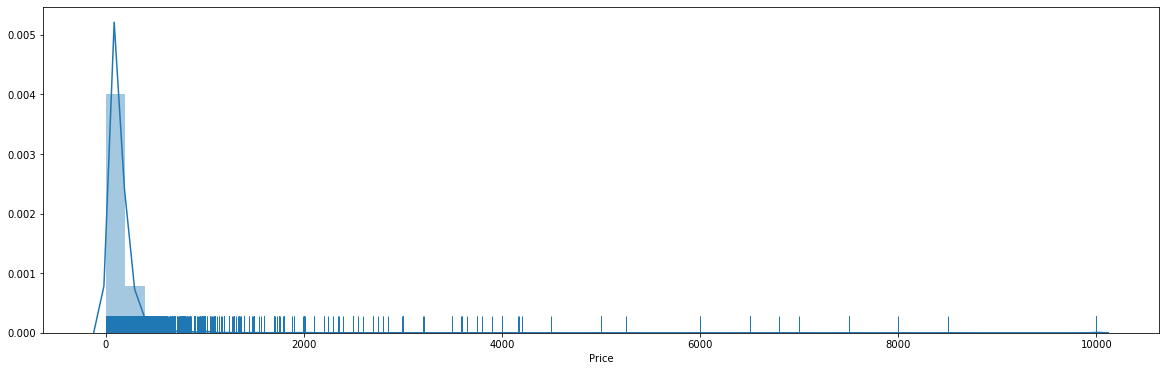

In [152]:
plt.figure(figsize=(20,6))
sb.distplot(df['Price'], rug=True)

In [153]:
df.dtypes

Unnamed: 0                     int64
host_response_rate             int32
Superhost                     object
host_neighbourhood            object
Borough                       object
latitude                     float64
longitude                    float64
property_type                 object
Room_Type                     object
accommodates                   int64
bathrooms                    float64
bedrooms                     float64
beds                           int64
bed_type                      object
Price                        float64
weekly_price                 float64
monthly_price                float64
security_deposit               int64
cleaning_fee                   int64
guests_included                int64
extra_people                 float64
availability_365               int64
number_of_reviews              int64
Review_Rating                  int64
review_scores_cleanliness      int64
review_scores_value            int64
dtype: object

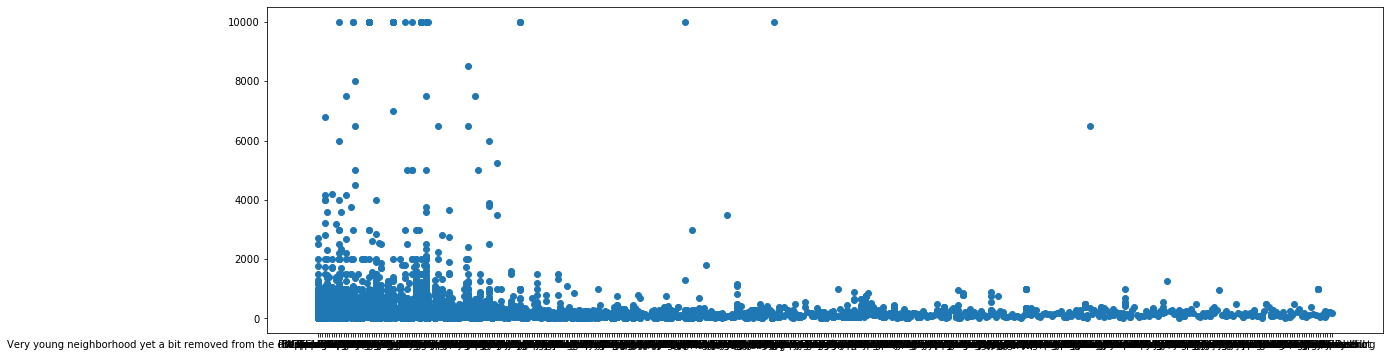

In [154]:
plt.figure(figsize=(20,6))
plt.scatter(df['host_neighbourhood'], df['Price'])

In [155]:
corr = df.corr()
corr

,Unnamed: 0,host_response_rate,latitude,longitude,accommodates,bathrooms,bedrooms,beds,Price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,availability_365,number_of_reviews,Review_Rating,review_scores_cleanliness,review_scores_value
Unnamed: 0,1.000000,0.309410,-0.009814,0.073713,0.061347,0.046087,0.045950,0.045211,0.033718,-0.204177,-0.181324,-0.042553,0.055390,0.028582,0.000154,0.167538,-0.170447,-0.115369,-0.108053,-0.114525
host_response_rate,0.309410,1.000000,-0.014452,0.103830,0.146204,0.066298,0.083194,0.128952,0.015324,-0.056280,0.009811,0.061516,0.216421,0.152851,0.129396,0.454461,0.288381,0.225100,0.240466,0.220999
latitude,-0.009814,-0.014452,1.000000,0.077338,-0.040072,-0.065559,-0.071660,-0.053120,0.029713,-0.004991,0.008745,0.020536,0.023328,-0.055792,-0.000764,-0.005718,-0.016413,-0.037096,-0.036762,-0.039421
longitude,0.073713,0.103830,0.077338,1.000000,-0.004247,0.007219,0.035591,0.014664,-0.112691,-0.074302,-0.061649,-0.091970,-0.169902,0.040270,0.020297,0.083672,0.058904,0.044766,0.051566,0.051277
accommodates,0.061347,0.146204,-0.040072,-0.004247,1.000000,0.342187,0.655265,0.743087,0.228735,0.084746,0.082785,0.169540,0.443419,0.572374,0.113019,0.141540,0.071523,0.052298,0.060577,0.048484
bathrooms,0.046087,0.066298,-0.065559,0.007219,0.342187,1.000000,0.421680,0.376092,0.150060,0.083241,0.053495,0.110554,0.207584,0.203526,0.048334,0.099289,-0.032370,-0.043208,-0.044052,-0.042670
bedrooms,0.045950,0.083194,-0.071660,0.035591,0.655265,0.421680,1.000000,0.664765,0.173747,0.093959,0.074334,0.138801,0.334927,0.437289,0.097612,0.078932,0.019217,0.009709,0.013468,0.009524
beds,0.045211,0.128952,-0.053120,0.014664,0.743087,0.376092,0.664765,1.000000,0.160936,0.090305,0.068260,0.141419,0.362435,0.491758,0.110063,0.136226,0.059122,0.043820,0.049896,0.041664
Price,0.033718,0.015324,0.029713,-0.112691,0.228735,0.150060,0.173747,0.160936,1.000000,0.057500,0.050563,0.105689,0.163423,0.108896,0.027434,0.064602,-0.041875,-0.074242,-0.068508,-0.077545
weekly_price,-0.204177,-0.056280,-0.004991,-0.074302,0.084746,0.083241,0.093959,0.090305,0.057500,1.000000,0.586222,0.112482,0.101795,0.079501,0.079634,-0.005203,0.094124,0.049271,0.046517,0.045199


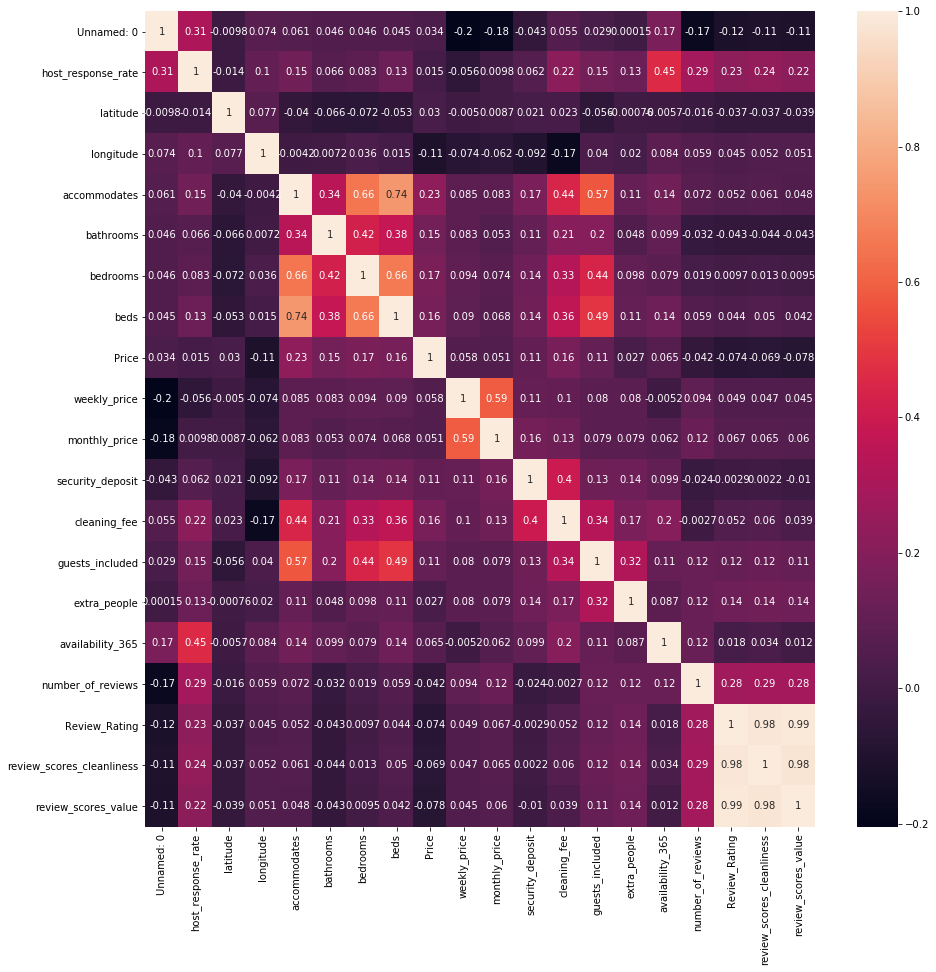

In [156]:
%matplotlib inline
plt.figure(figsize=(15, 15))
sb.heatmap(corr, annot=True)

In [157]:
import geopy.distance
cols =['latitude', 'longitude']
df['location'] = df[cols].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)

df['location'] =  df['location'].apply(lambda row: tuple(map(float, row.split(', '))))
df['location']
coords = (40.758896, -73.985130)
df['distance'] =  df['location'].apply(lambda row: geopy.distance.vincenty(coords, row).miles)
# print geopy.distance.vincenty(coords_1, coords_2).km

c:\users\cheikh_moctar\documents\ucf_bootcamp\ripos_git\class_repo\env\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


In [158]:
df['distance']

0        4.518910
1        5.602132
2        5.683554
3        1.148927
4        1.170857
           ...   
50594    6.538442
50595    2.457599
50596    1.888921
50597    1.432552
50598    5.804301
Name: distance, Length: 50599, dtype: float64

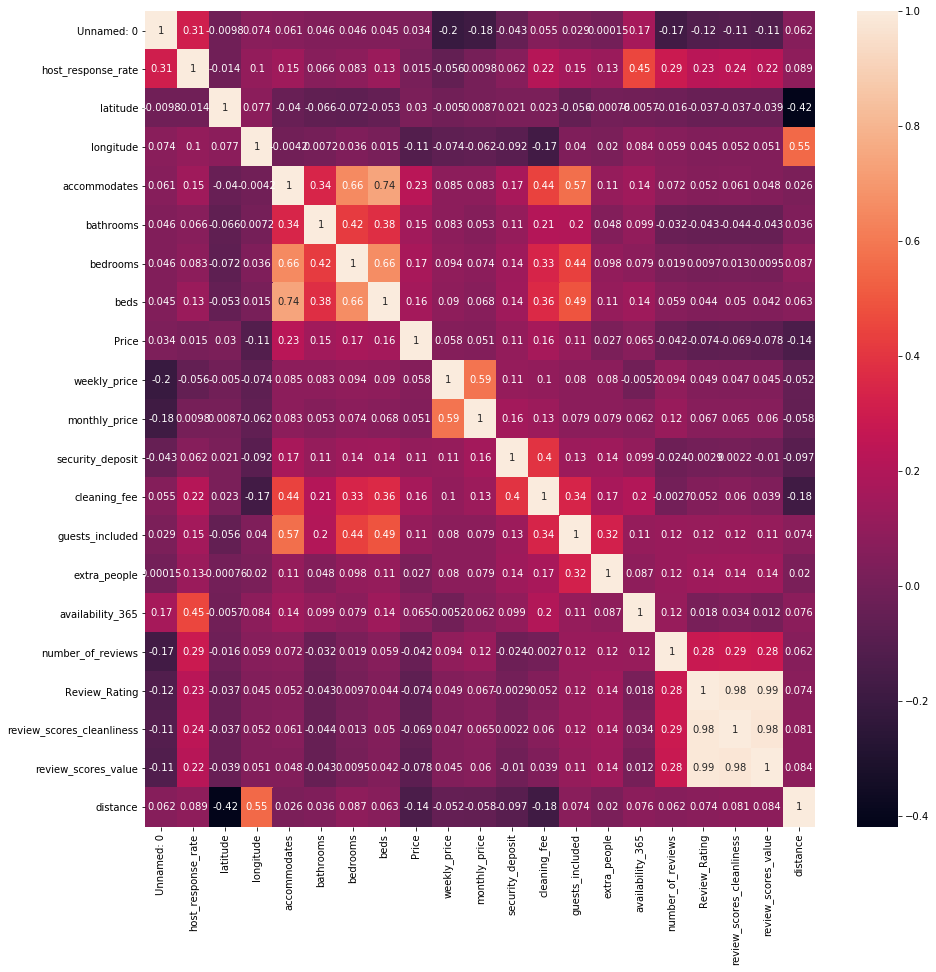

In [159]:
plt.figure(figsize=(15, 15))
corr = df.corr()
sb.heatmap(corr, annot=True)

  Using cached geographiclib-1.50-py3-none-any.whl (38 kB)
Note: you may need to restart the kernel to use updated packages.
